In [768]:
#Planetary Astrophysics Homework 4
#Tyler Nelson

import numpy as np
import scipy as sci
import math
import matplotlib.pyplot as plt
from functools import partial
from numpy import pi
import mpmath
from scipy import interpolate
from scipy import integrate
import random
from math import *
import corner
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import OldScalarFormatter, ScalarFormatter
#import emcee
mpmath.mp.prec = 50

plt.rcParams["figure.figsize"] = (7,7)
data = np.genfromtxt(r"/home/tyler/Desktop/rvDataPH4.txt")
#data[:,0] = data[:,0] 

In [ ]:
#structure: perform first mcmc without taking out data points, plot stuff and print parameters to check how we did
#determine if there are bad points 
#if yes, then remove them and run the mcmc again, plotting the same quantities

In [795]:



AU =1.5e13
Mj = 1.9e30
Msun = 2e33
yr = 3.15e7
G = 6.7e-8 

def newtonsMethod(f, fprime, guess, tolerance=1e0):
    curr, prev = guess, 2**31 -1
    while abs(curr - prev) > tolerance:
        prev, curr = curr,  curr - f(curr)/fprime(curr)
    return curr



def orbitFit(mStar, ecc):
    def secondFunction(m2sini, period, t0, t):
        n = 2*pi/period
        M = n*(t-t0)
        g = lambda E: E - ecc*sin(E) - M
        gPrime = lambda E: 1 - ecc*cos(E)
        E0 = newtonsMethod(g, gPrime, M)
        f = 2*atan2(sqrt(1+ecc)*sin(E0/2),sqrt(1-ecc)*cos(E0/2))
        return 28.4329/(1-ecc**2)*m2sini*(m2sini*Mj/Msun+mStar)**(-2/3)*(period/365)**(-1/3)*(np.cos(t0 + f)+ecc*np.cos(t0))
    return secondFunction

#2pi/period(t-t0)

def simpleOrbitFit(mStar):
    def returnFunction(m2sini, period, t0, t):
        return 28.4329*m2sini*(m2sini/1000+mStar)**(-2/3)*(period/365.25)**(-1/3)*np.sin( 2*pi/period*(t-t0))
    return returnFunction

def angleFunc(t0, period):
    return lambda t: (2*pi/period*(t-t0))%(2*pi)


In [578]:

def MCMC(f, M0, inputData, outputData, scalingList, limit=10000, args=[]):
    
    returnArray = [0]*limit
    
    l = len(M0)
    t = [0]*l
    chi0 = 0
    for i in range(len(inputData)):
        chi0 += (f(*M0, inputData[i]) - outputData[i])**2/abs(f(*M0, inputData[i]))    
    oldvalue = 0
    param = 0
    test = 0
    count = 0
    reject = [0]*l
    paramPing = [0]*l
    stats = [[] for i in range(l)]
    while count < limit:
        
        #tracks stats over time
        if(count%1000 == 999):
            for i in range(len(M0)):
                accept = 1-reject[i]/paramPing[i]
                stats[i].append(accept)
                reject[i] = paramPing[i] = 0
                
        #make a new param value
        param = random.randint(0, l-1)
        oldvalue = M0[param]
        M0[param] += random.gauss(0, scalingList[param])
        chisquared = 0
        for i in range(len(inputData)):
            chisquared += (f(*M0, inputData[i]) - outputData[i])**2/abs(f(*M0, inputData[i]))#f(*M0, inputData[i])
        #depending on function form and guess, sometimes might get complex output but
        #we observe real values
        
        if(type(chisquared) is complex):
            M0[param] = oldvalue
            reject[param]+=1
            paramPing[param]+=1
            continue
        elif chisquared > chi0:
            test = random.random()
            bar = math.exp((chi0-chisquared)/2)
            if test > bar:
                reject[param]+=1
                M0[param] = oldvalue
                chisquared = chi0
        paramPing[param]+=1
        chi0 = chisquared
        returnArray[count] = [*M0, chisquared, count]
        count+=1
    for i in stats:#print acceptance rates
        print(np.mean(i))
    return np.asarray(returnArray[int(limit/10):])
        

In [694]:

out = MCMC(simpleOrbitFit(1.10), [0.5, 3.524, np.median(data[:,0])], data[:,0], data[:,1], [0.07, 1e-5, 0.01],limit=40000)

/home/tyler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars
/home/tyler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in double_scalars


0.211706417865
0.629344770778
0.142569859258


In [803]:
#my attempts at plotting the 2d posteriors, the colors indicate chisqure value
# plt.scatter(out[:,1],out[:,0],c=out[:,-2])
# plt.ylabel("M(MJ)")
# plt.xlabel("Period(Days)")
# plt.show()

In [802]:
# plt.scatter(out[:,2],out[:,0],c=out[:,-2])
# plt.ylabel("M(MJ)")
# plt.xlabel("t0(Days)")
# plt.show()

In [801]:
# plt.scatter(out[:,2],out[:,1],c=out[:,-2])
# plt.ylabel("Period(days)")
# plt.xlabel("t0(Days)")
# plt.show()

In [583]:
bestFit = np.median(out, axis=0)
print(bestFit)
#median values, mass, period, t0, chisqure, last column is meaningless here

[  7.61669859e-01   3.51980619e+00   2.45188371e+06   7.98249806e+03
   2.19995000e+04]


In [584]:

predictions = partial(simpleOrbitFit(1.10),*bestFit[:3] )(data[:,0])

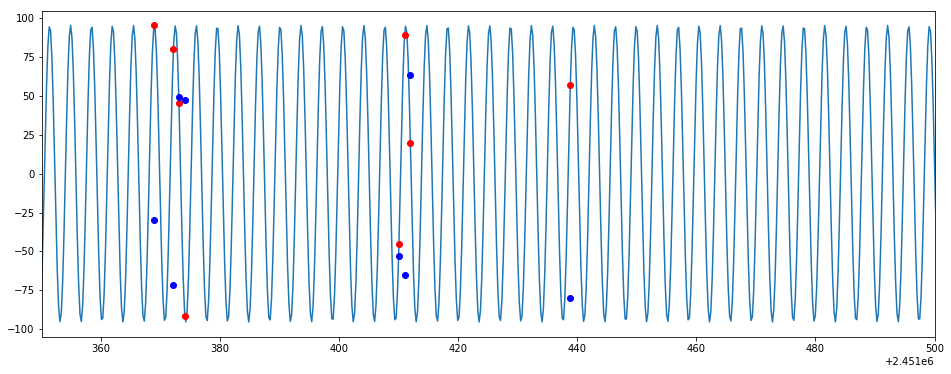

In [585]:
#check the fit
t=np.linspace(2451250, 2453500, 10000)
plt.plot(t,partial(simpleOrbitFit(1.10),*bestFit[:3] )(t))
plt.plot(data[:,0],predictions, 'ro')
plt.plot(data[:,0],data[:,1],'bo')
plt.xlim(2451350,2451500)
plt.show()

In [698]:
#confidence intervals
#question 4 or D
numOutputs = np.shape(out)[1]-2
for i in range(numOutputs):
    m = np.median(out[:,i])
    print(m,"-%f"%(m-np.percentile(out[:,i],16)),"+%f"%(np.percentile(out[:,i],84)-m))

0.78607100725 -0.011896 +0.011285
3.52419480503 -0.000008 +0.000008
2451883.81951 -0.001241 +0.001206


In [589]:
M2, T, t_0 = bestFit[:3]

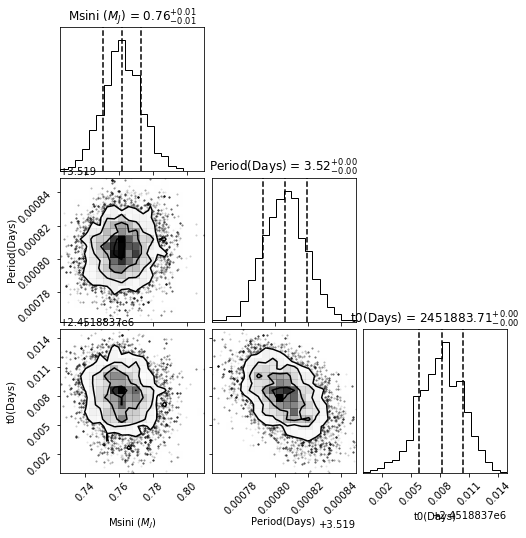

In [590]:
figure = corner.corner(out[:,:3], labels=[r"Msini ($M_J$)", r"Period(Days)", r"t0(Days)", "Msin(i)($M_J$)", "Msin(i)($M_J$)", "Period(Days)"],
                      quantiles=[0.16,0.5,0.84],
                      show_titles=True, title_kwargs={"fontsize":12})
plt.show()

In [606]:
angles = angleFunc(t_0, T)(t)

In [604]:
dataAngles = angleFunc(t_0, T)(data[:,0])

In [594]:
randints = np.random.randint(0,out.shape[0], size=100)

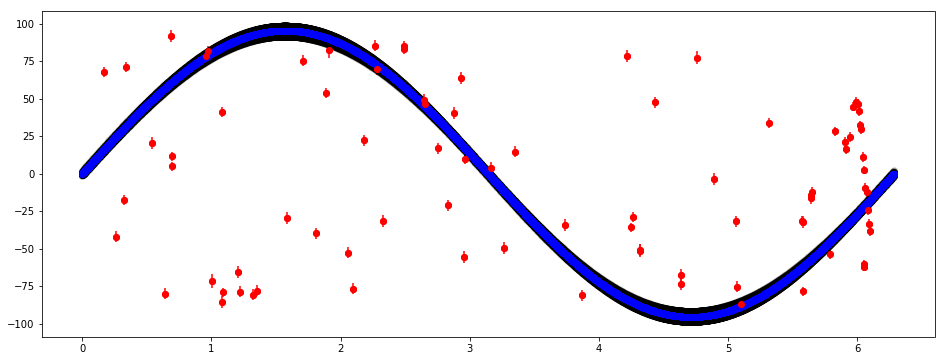

In [607]:
plt.errorbar(dataAngles, data[:,1], yerr = data[:,2], fmt='ro')
plt.plot(dataAngles, data[:,1],'ro')
for i in randints:
    plt.plot(angles,partial(simpleOrbitFit(1.10),*out[i,:3])(t),'ko',alpha=0.05)
    
plt.plot(angles, partial(simpleOrbitFit(1.10),*bestFit[:3])(t),'bo')
plt.show()

In [674]:
#by inspection the cluster of points near the end of the phase curve is suspect
dList = []
for i in range(len(dataAngles)):
    if(dataAngles[i]>5.8):
        print(i,dataAngles[i], data[i,0])
        dList.append(i)

22 5.82633969414 2451754.9793
23 5.90488383549 2451755.0233
24 5.91559440026 2451755.0293
25 5.94415590576 2451755.0453
26 5.9655770353 2451755.0573
27 5.99235344722 2451755.0723
28 6.00306401199 2451755.0783
29 6.01198948235 2451755.0833
30 6.02270004712 2451755.0893
31 6.03162551748 2451755.0943
32 6.04233608225 2451755.1003
33 6.05126155261 2451755.1053
34 6.06197211738 2451755.1113
35 6.07268268215 2451755.1173
36 6.08160815251 2451755.1223
37 6.09231871728 2451755.1283
38 6.10124418764 2451755.1333
83 6.04815332542 2453370.6946
84 6.05529370138 2453370.6986


In [675]:
data2 = np.delete(data, dList[:-2], axis=0)


In [699]:
print(np.median(data[:,0]))

2451883.7197


In [696]:
out2 = MCMC(simpleOrbitFit(1.10), [0.8, 3.524, np.median(data[:,0])], data2[:,0], data2[:,1], [0.07, 5e-5, 1e-2],limit=50000)

/home/tyler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in double_scalars


0.197433065568
0.286568111104
0.368689523726


In [798]:
#my own attempts of plotting the 2d posteriors
# plt.scatter(out2[:,1],out2[:,0],c=out2[:,-2])
# plt.ylabel("M(MJ)")
# plt.xlabel("Period(Days)")
# plt.show()

In [799]:
# plt.scatter(out2[:,2],out2[:,0],c=out2[:,-2])
# plt.ylabel("M(MJ)")
# plt.xlabel("t0(Days)")
# plt.show()

In [800]:
# plt.scatter(out[:,2],out[:,1],c=out[:,-2])
# plt.ylabel("Period(days)")
# plt.xlabel("t0(Days)")
# plt.show()

In [797]:
bestFit2 = np.median(out2[:,:3], axis=0)
print(bestFit2)

[  6.95941478e-01   3.52464257e+00   2.45188368e+06]


In [683]:
predictions2 = partial(simpleOrbitFit(1.10),*bestFit2[:3] )(data2[:,0])

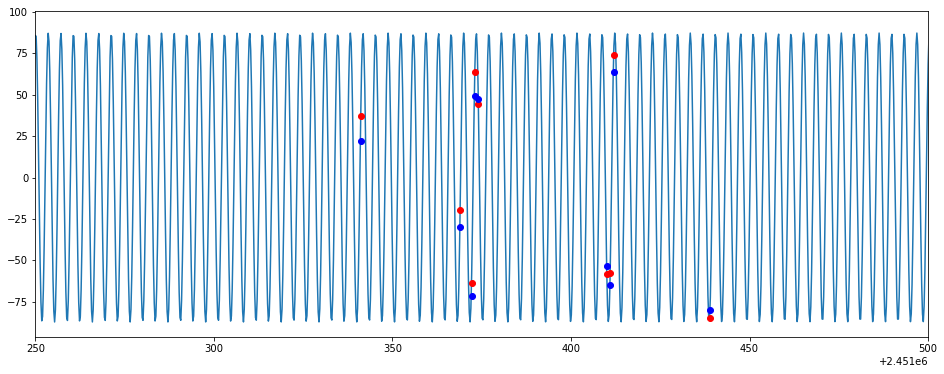

In [684]:
t=np.linspace(2451250, 2453500, 10000)
plt.plot(t,partial(simpleOrbitFit(1.10),*bestFit2[:3] )(t))
plt.plot(data2[:,0],predictions2, 'ro')
plt.plot(data2[:,0],data2[:,1],'bo')
plt.xlim(2451250,2451500)
plt.show()

In [685]:
numOutputs2 = np.shape(out2)[1]-2
for i in range(numOutputs2):
    m = np.median(out2[:,i])
    print(m,"-%f"%(m-np.percentile(out2[:,i],16)),"+%f"%(np.percentile(out2[:,i],84)-m))

0.696984939336 -0.011318 +0.010907
3.52486743252 -0.000011 +0.000012
2451883.70283 -0.003964 +0.003510


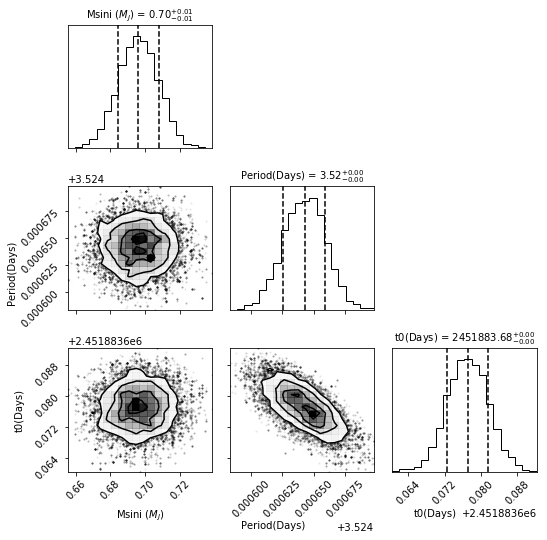

In [793]:
figure = corner.corner(out2[:,:3], labels=[r"Msini ($M_J$)", r"Period(Days)", r"t0(Days)", "Msin(i)($M_J$)", "Msin(i)($M_J$)", "Period(Days)"],
                      quantiles=[0.16,0.5,0.84],
                      show_titles=True, title_kwargs={"fontsize":10})

plt.tight_layout()
pltlist = list(enumerate(figure.axes))#fix the bad labels manually
pltlist[7][1].xaxis.set_label_coords(0.3, -0.4)
pltlist[3][1].yaxis.set_label_coords(-0.35, 0.3)
pltlist[8][1].xaxis.set_label_coords(0.3, -0.3)
plt.savefig("/home/tyler/Desktop/Planets/posteriors.png",dpi=400)

plt.show()

In [687]:
M_2, T_2,t_02 = bestFit2[:3]

In [688]:
dataAngles2 = angleFunc(t_02, T_2)(data2[:,0])

In [689]:
randints2 = np.random.randint(0,out2.shape[0], size=100)

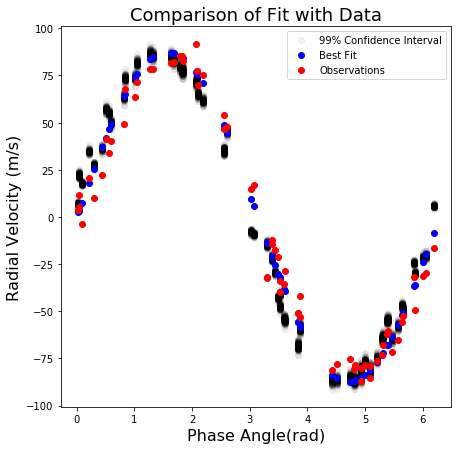

In [794]:

for i in randints2[:-1]:
    plt.plot(dataAngles2,partial(simpleOrbitFit(1.10),*out2[i,:3])(data2[:,0]),'ko',alpha=0.05)

plt.plot(dataAngles2, partial(simpleOrbitFit(1.10),*out2[randints2[-1],:3])(data2[:,0]),'ko',alpha=0.05,label="99% Confidence Interval")
plt.plot(dataAngles2, partial(simpleOrbitFit(1.10),*bestFit2[:3])(data2[:,0]),'bo',label="Best Fit")
plt.plot(dataAngles2, data2[:,1],'ro',label="Observations")
plt.xlabel("Phase Angle(rad)", fontsize=16)
plt.ylabel("Radial Velocity (m/s)", fontsize=16)
plt.title("Comparison of Fit with Data",fontsize=18)
plt.legend()
plt.savefig("/home/tyler/Desktop/Planets/rv.png",dpi=400)
plt.show()